In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [176]:
#read all csv files
customer = pd.read_csv("Case Study - Customer.csv", sep=";")
transaction = pd.read_csv("Case Study - Transaction.csv", sep=";")
product = pd.read_csv("Case Study - Product.csv", sep=";")
store = pd.read_csv("Case Study - Store.csv", sep=";")

### **Pre Processing Data "Customer"**

In [177]:
#check head and shape
print(customer.head())
print(customer.shape)

   CustomerID  Age  Gender Marital Status Income
0           1   55       1        Married   5,12
1           2   60       1        Married   6,23
2           3   32       1        Married   9,17
3           4   31       1        Married   4,87
4           5   58       1        Married   3,57
(447, 5)


In [178]:
#check dtype
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


There is an error in the 'Income' variable where it should be of float data type.

In [179]:
# Replace comma (,) with period (.) and convert to float data type
customer['Income'] = customer['Income'].str.replace(',', '.').astype(float)

# Then, convert to integer data type (if you want it as an integer)
customer['Income'] = customer['Income'].astype(int)


In [180]:
#Check duplicate data
duplicate_customer_ids = customer[customer.duplicated(subset='CustomerID', keep=False)]
print("Rows with Duplicate CustomerIDs:")
print(duplicate_customer_ids)


Rows with Duplicate CustomerIDs:
Empty DataFrame
Columns: [CustomerID, Age, Gender, Marital Status, Income]
Index: []


In [181]:
# Count missing values in each column
missing_values = customer.isnull().sum()

# Display the result
print("Check Missing Values\n")
print(missing_values)

Check Missing Values

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64


Based on the output above, we can see that there is only one variable with missing values, which is "Marital Status" (Categorical). To handle this, we can use KNN imputation. However, before using KNN, it's important to check for noisy data to make sure it doesn't disrupt the Euclidean distance calculations.

In [182]:
customer.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,447.0,224.000000,129.182042,1.0,112.5,224.0,335.5,447.0
Age,447.0,39.782998,12.848719,0.0,30.0,39.0,50.5,72.0
Gender,447.0,0.458613,0.498842,0.0,0.0,0.0,1.0,1.0
Income,447.0,8.109620,6.569673,0.0,4.0,7.0,10.0,71.0


Looking at the output above, it's evident that the "Age" variable has a minimum value of 0, which is quite unusual and may suggest the presence of noisy data. Consequently, it's crucial to conduct a comprehensive examination of this variable.

Note:
+ "CustomerID" serves as the primary key where each customer is assigned a unique ID that distinguishes them from others.
+ "Gender" is a categorical variable that has been encoded in the original CSV data.
+ Even though the maximum "Income" significantly differs from the median, the data is not considered noise because a monthly income in millions of Indonesian Rupiah is still reasonable for 71.3, although it may be considered an outlier.


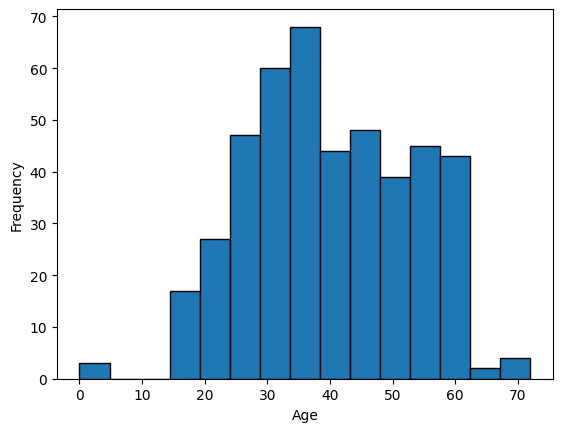

In [183]:
import matplotlib.pyplot as plt

# Retrieve the "Age" data from the "customer" dataframe
age_data = customer['Age']

# Create a histogram
plt.hist(age_data, bins=15, edgecolor='black')  # You can adjust the number of bins as needed

# Add the x-axis label
plt.xlabel('Age')

# Add the y-axis label
plt.ylabel('Frequency')

# Display the histogram
plt.show()


In [184]:
# Calculate the frequency of each age value
age_frequency = customer['Age'].value_counts().reset_index()
age_frequency.columns = ['Age', 'Frequency']

# Sort the results based on age from lowest to highest
age_frequency_sorted = age_frequency.sort_values(by='Age')

# Display the sorted results
print(age_frequency_sorted)


    Age  Frequency
50    0          1
51    2          1
52    3          1
32   18          7
18   19         10
41   20          5
38   21          6
24   22          9
36   23          7
30   24          8
19   25         10
8    26         13
29   27          8
31   28          8
16   29         11
27   30          9
2    31         16
21   32         10
4    33         14
1    34         17
6    35         13
11   36         12
3    37         14
10   38         12
23   39          9
13   40         12
17   41         11
43   42          5
34   43          7
12   44         12
0    45         18
22   46          9
26   47          9
20   48         10
28   49          8
44   50          3
7    51         13
39   52          5
9    53         12
14   54         12
25   55          9
37   56          7
42   57          5
35   58          7
15   59         11
5    60         13
33   61          7
40   62          5
49   65          1
48   66          1
46   68          1
53   69     

Looking at the age distribution, it appears that there is an anomaly, as it is more likely that the customer's age is above 18.

In [185]:
 customer[customer['Age'] < 18]

,CustomerID,Age,Gender,Marital Status,Income
11,12,2,1,Married,4
73,74,3,1,Married,5
127,128,0,1,Married,6


In [186]:
# Set the age values below 18 to NaN
customer.loc[customer['Age'] < 18, 'Age'] = np.nan

customer[customer['Age'].isna()]


,CustomerID,Age,Gender,Marital Status,Income
11,12,NaN,1,Married,4
73,74,NaN,1,Married,5
127,128,NaN,1,Married,6


Next, we can use KNN imputation to handle missing values.

In [187]:
# Display only the rows that have missing values
rows_with_missing_values = customer[customer.isna().any(axis=1)]

# Display the indices (rows) that have missing values
print("Rows with missing values:\n")
print(rows_with_missing_values)


Rows with missing values:

     CustomerID   Age  Gender Marital Status  Income
9            10  34.0       1            NaN       4
11           12   NaN       1        Married       4
73           74   NaN       1        Married       5
127         128   NaN       1        Married       6
415         416  27.0       1            NaN       3
442         443  33.0       1            NaN       9


In [188]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of the LabelEncoder class
le = LabelEncoder()

# Fit the encoder to the 'Marital Status' variable and transform it
customer['Marital Status'] = le.fit_transform(customer['Marital Status'])

# Create a dictionary to map original values to encoded values
label_encoder_dict = {label: encoded for label, encoded in zip(le.classes_, le.transform(le.classes_))}

# Print the label encoder dictionary
print(label_encoder_dict)


{'Married': 0, 'Single': 1, nan: 2}


In [189]:
# Set the age values below 18 to NaN
customer.loc[customer['Marital Status'] == 2, 'Marital Status'] = np.nan

customer[customer['Marital Status'].isna()]


,CustomerID,Age,Gender,Marital Status,Income
9,10,34.0,1,NaN,4
415,416,27.0,1,NaN,3
442,443,33.0,1,NaN,9


In [190]:
# Dataframe without missing values (for training)
training_data = customer.dropna()
training_data = training_data.drop(columns=['CustomerID'])


In [191]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Data and target to be used for KNN
X = training_data[['Age', 'Gender', 'Marital Status', 'Income']]  # feature
y = training_data['Age']  # target column

# List of K values to be tested
k_values = [1, 2, 3, 5, 7, 9]

# Initialize a list to store cross-validation scores for each K value
cross_val_scores = []

# Perform cross-validation for each K value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5)  # You can change the number of CV folds as needed
    cross_val_scores.append(np.mean(scores))

# Find the best K value that yields the highest score
best_k = k_values[np.argmax(cross_val_scores)]

print("Cross-Validation Scores for Different K Values:", cross_val_scores)
print("Optimal K:", best_k)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores for Different K Values: [0.6576608784473953, 0.5465781409601635, 0.5442288049029622, 0.5351123595505618, 0.46935648621041876, 0.4445097037793667]
Optimal K: 1


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [192]:
# Data and target to be used for KNN
X = training_data[['Age', 'Gender', 'Marital Status', 'Income']]  # feature
y = training_data['Marital Status']  # target column

# List of K values to be tested
k_values = [1, 2, 3, 5, 7, 9]

# Initialize a list to store cross-validation scores for each K value
cross_val_scores = []

# Perform cross-validation for each K value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5)  # You can change the number of CV folds as needed
    cross_val_scores.append(np.mean(scores))

# Find the best K value that yields the highest score
best_k = k_values[np.argmax(cross_val_scores)]

print("Cross-Validation Scores for Different K Values:", cross_val_scores)
print("Optimal K:", best_k)

Cross-Validation Scores for Different K Values: [0.9068947906026559, 0.8933605720122573, 0.9069458631256383, 0.9046731358529112, 0.8933350357507661, 0.8865168539325843]
Optimal K: 3


From the search for the most optimal K with Cross Validation, it was found that the optimal K for the "Age" variable is K: 1, and for the "Marital Status" variable is K: 3. However, **it was decided to use K: 1 for both variables** because even though "Marital Status" is more optimal at K: 3, the Cross-Validation Scores are not significantly different between K: 1 and K: 3 for "Marital Status."

In [193]:

from fancyimpute import KNN
# Create a copy of the 'customer' dataframe to store the imputed values
customer_imputed = customer.copy()

# Perform KNN imputation on multiple columns
columns_to_impute = ['Age', 'Marital Status']
imputer = KNN(k=1)
imputed_values = imputer.fit_transform(customer_imputed[columns_to_impute].values).astype(int)

# Assign the imputed values back to the respective columns
customer_imputed[columns_to_impute] = imputed_values

# Display the imputed data
print(customer_imputed)


Imputing row 1/447 with 0 missing, elapsed time: 0.042
Imputing row 101/447 with 0 missing, elapsed time: 0.043
Imputing row 201/447 with 0 missing, elapsed time: 0.044
Imputing row 301/447 with 0 missing, elapsed time: 0.045
Imputing row 401/447 with 0 missing, elapsed time: 0.046
     CustomerID  Age  Gender  Marital Status  Income
0             1   55       1               0       5
1             2   60       1               0       6
2             3   32       1               0       9
3             4   31       1               0       4
4             5   58       1               0       3
..          ...  ...     ...             ...     ...
442         443   33       1               0       9
443         444   53       0               0      15
444         445   51       0               0      14
445         446   57       0               0       7
446         447   54       1               0      20

[447 rows x 5 columns]


In [194]:
# Compare 'customer_imputed' with the original 'customer' to find replaced rows
replaced_rows = customer_imputed[columns_to_impute] != customer[columns_to_impute]

# Display rows where imputation has occurred
imputed_rows = customer_imputed[replaced_rows.any(axis=1)]
print(imputed_rows)


     CustomerID  Age  Gender  Marital Status  Income
9            10   34       1               0       4
11           12   55       1               0       4
73           74   55       1               0       5
127         128   55       1               0       6
415         416   27       1               0       3
442         443   33       1               0       9


In [195]:
#New Descriptive Statistics
customer_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,447.0,224.000000,129.182042,1.0,112.5,224.0,335.5,447.0
Age,447.0,40.140940,12.519413,18.0,31.0,39.0,51.0,72.0
Gender,447.0,0.458613,0.498842,0.0,0.0,0.0,1.0,1.0
Marital Status,447.0,0.232662,0.423002,0.0,0.0,0.0,0.0,1.0
Income,447.0,8.109620,6.569673,0.0,4.0,7.0,10.0,71.0


In [196]:
customer_imputed.to_csv('Customer(fix).csv', index=False)

### **Pre Processing Data "Product"**

In [197]:
print(product)

  ProductID   Product Name  Price
0        P1      Choco Bar   8800
1        P2  Ginger Candy    3200
2        P3       Crackers   7500
3        P4    Potato Chip  12000
4        P5       Thai Tea   4200
5        P6         Cashew  18000
6        P7   Coffee Candy   9400
7        P8            Oat  16000
8        P9        Yoghurt  10000
9       P10   Cheese Stick  15000


In [198]:
#check dtype
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


No data types are incorrect in the dataframe product

In [199]:
product.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10.0,10410.0,4890.455557,3200.0,7825.0,9700.0,14250.0,18000.0


There are no data anomalies such as noise, missing values, or other issues. As a result, the data is considered clean

In [200]:
product.to_csv('Product(fix).csv', index=False)

### **Pre Processing Data "Store"**


In [201]:
print(store)

    StoreID         StoreName    GroupStore           Type   Latitude  \
0         1     Prima Tendean         Prima   Modern Trade       -6,2   
1         2  Prima Kelapa Dua         Prima   Modern Trade  -6,914864   
2         3        Prima Kota         Prima   Modern Trade  -7,797068   
3         4       Gita Ginara          Gita  General Trade  -6,966667   
4         5           Bonafid          Gita  General Trade  -7,250445   
5         6            Lingga        Lingga   Modern Trade  -5,135399   
6         7       Buana Indah         Buana  General Trade   3,316694   
7         8     Sinar Harapan  Harapan Baru  General Trade    5,54829   
8         9            Lingga        Lingga   Modern Trade  -3,654703   
9        10      Harapan Baru  Harapan Baru  General Trade   3,597031   
10       11     Sinar Harapan      Prestasi  General Trade   0,533505   
11       12    Prestasi Utama      Prestasi  General Trade  -2,990934   
12       13             Buana         Buana  Genera

In [202]:
print(store.info())
print(store.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes
None
(14, 6)


There are no data anomalies such as noise, missing values, or other issues. As a result, the data is considered clean

In [203]:
store.to_csv('Store(fix).csv', index=False)

### **Pre Processing Data "Transaction"**

In [204]:
print(transaction)

     TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0          TR11369         328  01/01/2022        P3   7500    4        30000   
1          TR16356         165  01/01/2022        P9  10000    7        70000   
2           TR1984         183  01/01/2022        P1   8800    4        35200   
3          TR35256         160  01/01/2022        P1   8800    7        61600   
4          TR41231         386  01/01/2022        P9  10000    1        10000   
...            ...         ...         ...       ...    ...  ...          ...   
5015       TR54423         243  31/12/2022       P10  15000    5        75000   
5016        TR5604         271  31/12/2022        P2   3200    4        12800   
5017       TR81224          52  31/12/2022        P7   9400    6        56400   
5018       TR85016          18  31/12/2022        P8  16000    3        48000   
5019       TR85684          55  31/12/2022        P8  16000    1        16000   

      StoreID  
0          

In [205]:
print(transaction.info())
print(transaction.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB
None
(5020, 8)


In [206]:
#Changing the data type of the "Date" column to datetime with the "DD/MM/YYYY" format
transaction['Date'] = pd.to_datetime(transaction['Date'], format='%d/%m/%Y')
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 313.9+ KB


In [207]:
transaction[transaction.duplicated(keep=False)]

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID


There are no duplicate data.

In [208]:
transaction.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,5020.0,221.263745,129.672955,1.0,108.0,221.0,332.0,447.0
Price,5020.0,9684.800797,4600.708780,3200.0,4200.0,9400.0,15000.0,18000.0
Qty,5020.0,3.644622,1.855295,1.0,2.0,3.0,5.0,10.0
TotalAmount,5020.0,32279.482072,19675.462455,7500.0,16000.0,28200.0,47000.0,88000.0
StoreID,5020.0,7.489841,4.028502,1.0,4.0,7.0,11.0,14.0


There is no clear indication of noise in the data for any of the variables. The statistics appear to be within expected ranges for the respective types of data, such as  prices, quantities, and total amounts

In [209]:
transaction.to_csv('Transaction(fix).csv', index=False)